### 7.1.1 学习表征
另一种预测这个领域发展的方法————观察图像特征的提取方法。在2012年前，图像特征都是机械地计算出来的。事实上，设计一套新的特征函数、改进结果，并撰写论文是盛极一时的潮流。SIFT (Lowe, 2004)、SURF (Bay et al., 2006)、HOG（定向梯度直方图） (Dalal and Triggs, 2005)、bags of visual words和类似的特征提取方法占据了主导地位。

另一组研究人员，包括Yann LeCun、Geoff Hinton、Yoshua Bengio、Andrew Ng、Shun ichi Amari和Juergen Schmidhuber，想法则与众不同：他们认为特征本身应该被学习。此外，他们还认为，在合理地复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。在机器视觉中，最底层可能检测边缘、颜色和纹理。事实上，Alex Krizhevsky、Ilya Sutskever和Geoff Hinton提出了一种新的卷积神经网络变体AlexNet。在2012年ImageNet挑战赛中取得了轰动一时的成绩。AlexNet以Alex Krizhevsky的名字命名，他是论文 (Krizhevsky et al., 2012)的第一作者。

有趣的是，在网络的最底层，模型学习到了一些类似于传统滤波器的特征抽取器。 图7.1.1是从AlexNet论文 (Krizhevsky et al., 2012)复制的，描述了底层图像特征。  
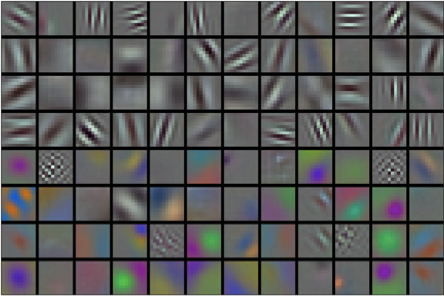

### 7.1.2 AlexNet
From LeNet to AlexNet:  
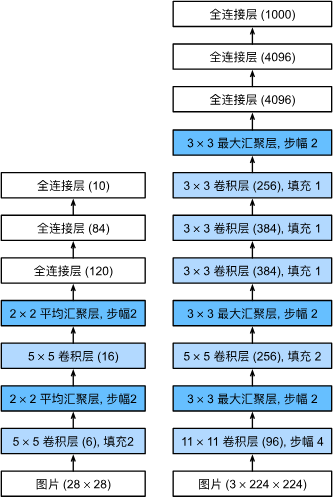
#### 7.1.2.1. 模型设计
在AlexNet的第一层，卷积窗口的形状是
。 由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。 第二层中的卷积窗口形状被缩减为
，然后是
。 此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为
、步幅为2的最大汇聚层。 而且，AlexNet的卷积通道数目是LeNet的10倍。

在最后一个卷积层后有两个全连接层，分别有4096个输出。 这两个巨大的全连接层拥有将近1GB的模型参数。 由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。 幸运的是，现在GPU显存相对充裕，所以现在很少需要跨GPU分解模型（因此，本书的AlexNet模型在这方面与原始论文稍有不同）。

#### 7.1.2.2. 激活函数
此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。 一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。 另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。 当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。 相反，ReLU激活函数在正区间的梯度总是1。 因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。

#### 7.1.2.3. 容量控制和预处理
AlexNet通过暂退法（ 4.6节）控制全连接层的模型复杂度，而LeNet只使用了权重衰减。 为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。 这使得模型更健壮，更大的样本量有效地减少了过拟合。 在 13.1节中更详细地讨论数据扩增。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [3]:
#7.1.3 读取数据集
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.327, train acc 0.879, test acc 0.876
1506.9 examples/sec on cuda:0


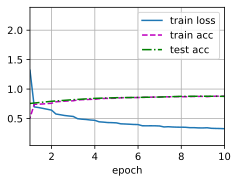

In [4]:
#7.1.4. 训练AlexNet
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())